# Addressing Star Formation Rate Histories
## Incorporating SFR into Existing Analyses
`-- Leo Lonzarich, 21 April 2022 // [Updated 6-5-22] --`

---


### Table of Contents
- [Extracting SFR Histories](#histories)
- [SN-heated Gas Fractions](#fracs)
    - [Tracking SFR Alongside SN-heated Gas Fractions](#trackfracs)
- [Mass Loading](#massload)





### General Comments on Data/Contents of this Noteboook
- This is the thir installment of work tied to Spring 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `heated`: Gas particles in `discharged` that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from `discharged` with `snHeated==True`.)
- `preheated`: Similar to `predischarged`; Consists of the same particles in `heated`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)



In [1]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import tqdm
from scipy import interpolate


from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import *

In [2]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
# quick check to ensure all selected satellites are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29


In [4]:
# importing all data.
predischarged, hot_predischarged, discharged = read_all_discharged()
all_accreted, reaccreted = read_accreted()

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

sngas = read_sngas()  # all SN-heated

> Returning (predischarged, discharged, hot_predischarged) for all satellites <
> Returning (accreted, reaccreted) for all satellites <
> Returning (SN-heated gas) for all satellites <


In [5]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())


# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2
                            + (gas['host_Yc'] - gas['sat_Yc'])**2
                            + (gas['host_Zc'] - gas['sat_Zc'])**2
                           )/ gas['hostRvir']
                   )

## Extracting SFR Histories: <a class="anchor" id="histories"></a>

Collecting SFR histories from txt files for satellite sample:

`['h148_12','h148_27','h148_34','h148_38','h148_55','h148_65','h148_249',
 'h148_251','h148_282','h229_14','h229_18','h229_20','h229_22',
 'h229_49','h242_21','h242_38','h242_69','h329_29','h329_117']`

---
---


In [7]:
# read txt files into pandas DataFrame
keys = get_keys()
sfrData = pd.DataFrame([])

for key in keys:   
    sim = key[:4]
    haloid = int(key[5:])

    data = pd.read_csv(f'{rootPath}Stellar_Feedback_Code/SFRData/{sim}_{haloid}sfh.txt',
                       sep=' ')
    data = data.iloc[:,[0,1]]  # dropping erroneous columns.
    data['key'] = key
    data = data.rename({'#':'time', 'Time':'sfr'}, axis='columns')

    sfrData = pd.concat([sfrData, data])

In [8]:
# calculating expelled gas. See `StellarFeedbackAnalysis` for more info.

y = np.array(discharged['pid'])  # particle ids of discharged gas...
x = np.array(reaccreted['pid'])  # ...and for reaccreted.

# applying mask:
index = np.argsort(x)
sorted_x = x[index]  # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
expelled = discharged.iloc[result[result.mask].data]  # permanently discharged gas.

hot_exp = expelled[expelled['snHeated']==True]  # SN-heated, expelled gas.
cold_exp = expelled[expelled['snHeated']==False]  # unheated, expelled.

### Splicing SFR Histories with PAI Data <a class="anchor" id="splice"></a>

Plots in `ReaccretionAnalysis` show that SN-heating ratios increasing with <<PAI. However, this would appear contradictory, as satellites were selected because they quench, and this quenching is maximized at <<PAI. Since quenching is characteristic of <<SFRs, and since stellar feedback follows bursts of star formation, we should expect SN-heated discharged gas to drop off in regime of small PAI...

---


## Fractions of Gas SN-heated: <a class="anchor" id="fracs"></a>

---
---


### Tracking SFR + Fractions of SN-heated gas discharged Over Time <a class="anchor" id="trackfracs"></a>

---


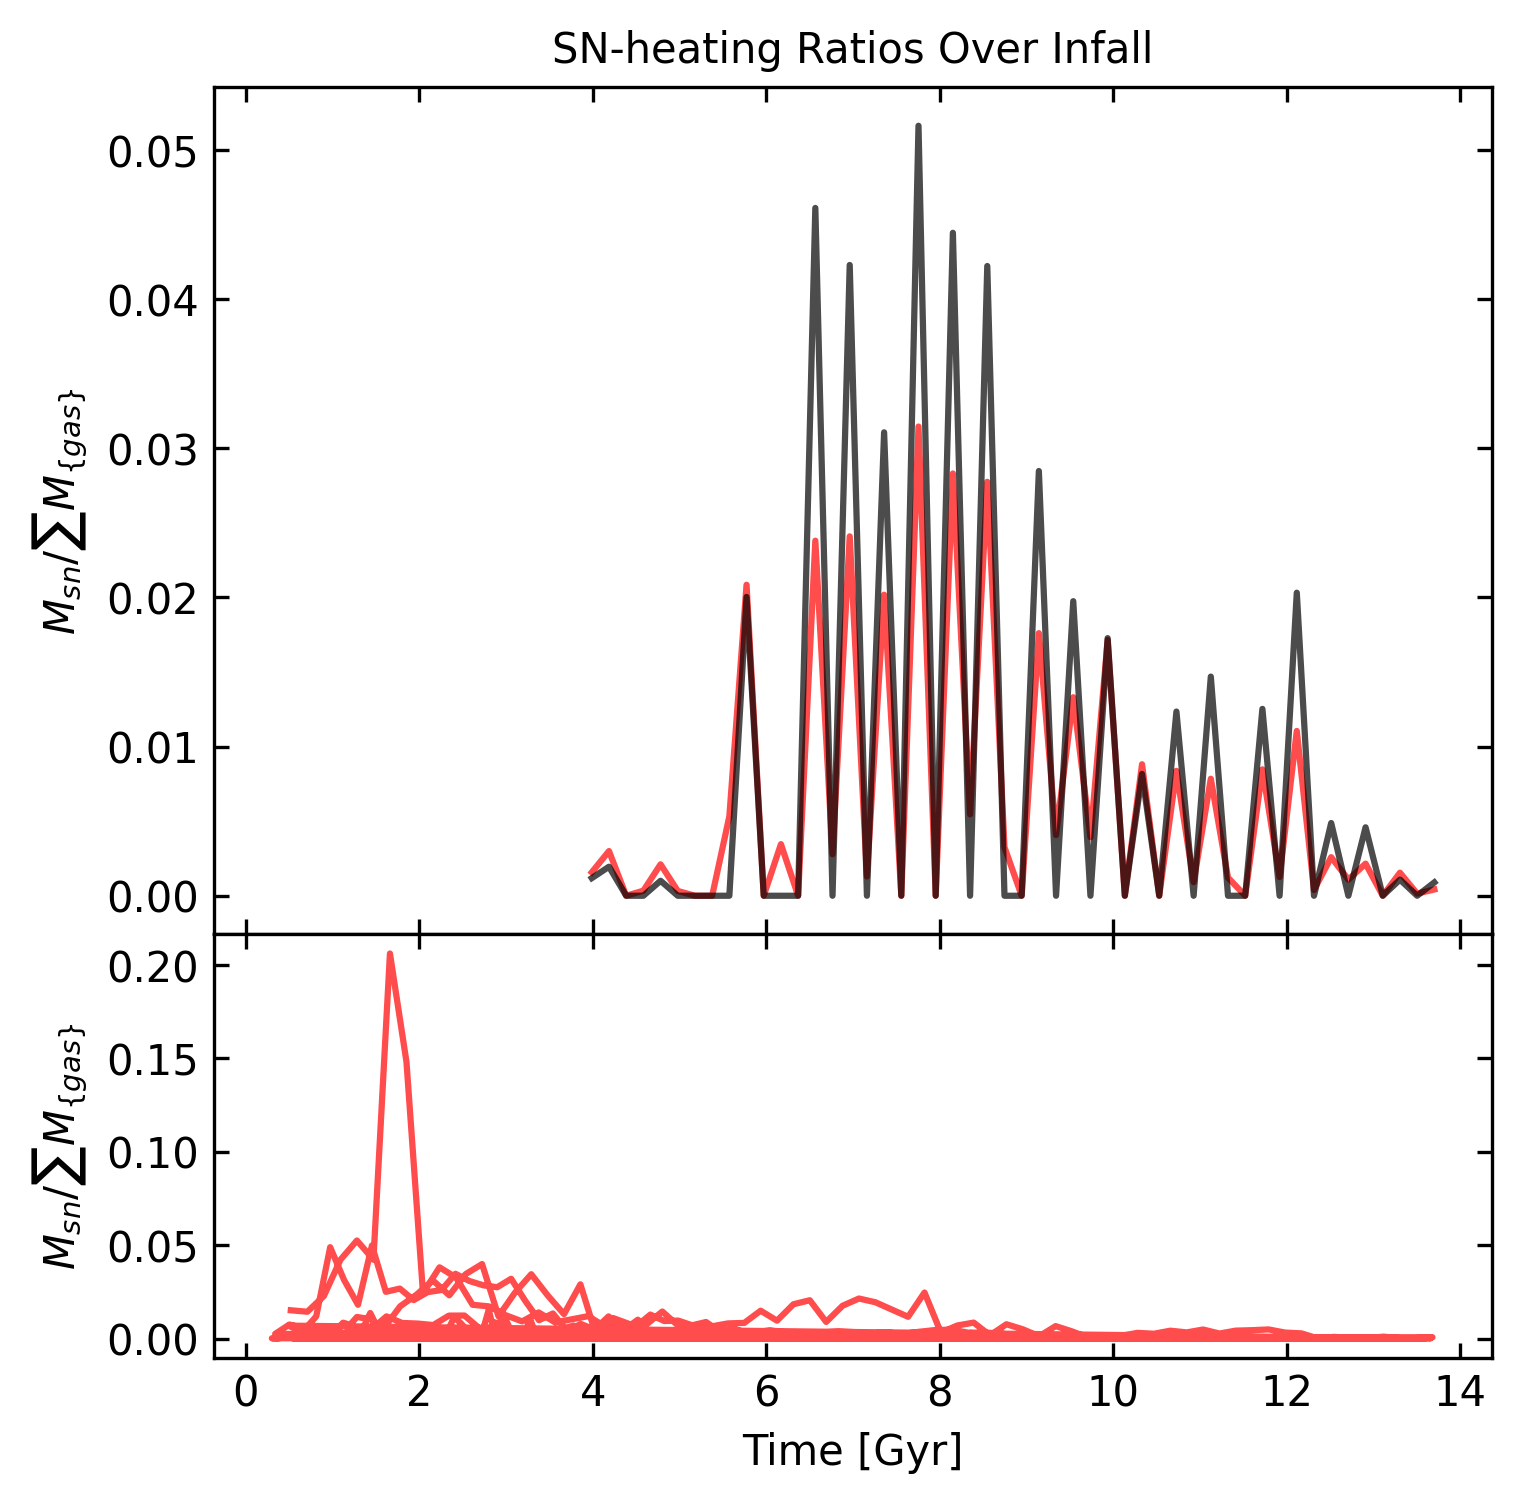

In [10]:
hot_dsrg = discharged[discharged.snHeated==True]

bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)


## plot 1 ###
y1, x = np.histogram(hot_dsrg.time, bins=bins, weights=wt(hot_dsrg, discharged))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(discharged.time, bins=bins, weights=wt(discharged))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

y3, x = np.histogram(hot_exp.time, bins=bins, weights=wt(hot_exp, expelled))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y4, x = np.histogram(expelled.time, bins=bins, weights=wt(expelled))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

# ax0.plot(bincenters[y2>0], (y1/y2)[y2>0], alpha=0.7, color='r', label='Discharged Gas')         
ax0.plot(bincenters, y1, alpha=0.7, color='r', label='Discharged Gas')         
ax0.plot(bincenters, y3, alpha=0.7, color='black', label='Expelled Gas')         





### plot 2 ###
# y1, x = np.histogram(time, bins=bins)
# bincenters = 0.5*(x[1:] + x[:-1])
# sum1 = np.cumsum(y1)

ax1.plot(np.array(sfrData.time), np.array(sfrData.sfr), alpha=0.7, color='r') 


ax0.set_title('SN-heating Ratios Over Infall',
              fontsize='medium')
ax0.set_xlabel(r'$PAI / R_{vir}$')
ax0.set_ylabel('$M_{sn} / \sum M_{\{gas\}}$')
# ax0.legend(frameon=False, fontsize=7)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
# ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel('Time [Gyr]')
ax1.set_ylabel('$M_{sn} / \sum M_{\{gas\}}$')
# ax1.set_ylim(0,1)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
# ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('S22plots/PAIperRvir_sn3.pdf')
plt.show()

## Mass-Loading: <a class="anchor" id="massload"></a>

One way to observe astronomical flows in our simulations is by defining a `mass-loading` rate

$$
\eta = \frac{\text{Instantaneous Mass-loss}}{\text{SFR}} ,
$$

or

$$
\eta_{sn} = \frac{\text{SN-heated Gas Mass}}{\text{SFR}} .
$$

- We address mass loading at each sim timestep for each of the selected satellites.
- Just as well, we play around with different numerators to see if anything interesting comes up.
- [Referencing Christensen 2016].
---
---




In [20]:
# compiling all tracked gas particles:
allGas = pd.DataFrame()

keys = get_keys()

for i,key in enumerate(keys):
    i += 1
    allGas1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5',
                          key=key)
    allGas1['key'] = key
    allGas = pd.concat([allGas, allGas1])

In [36]:
key = 'h148_12'
gas = allGas[allGas.key==key]
sfr = sfrData[sfrData.key==key]

# interpolation to approximate unavailable sfr data.
t2 = np.unique(gas.time)
t1, uniq_ind = np.unique(sfr.time, return_index = True)
x1 = sfr.iloc[uniq_ind]
x1 = x1.sfr

f = interpolate.interp1d(x1,t1, fill_value='extrapolate')
x2 = f(t2)

x2

array([-21.75262666, -23.16783587, -24.58304508, -25.93191636,
       -27.41346351, -28.82867272, -30.24388193, -31.65909115,
       -33.01901875, -33.07430036, -34.48950957, -35.90471878,
       -37.319928  , -37.56316708, -38.73513721, -40.15034642,
       -41.56555563, -42.98076485])

In [38]:
gas

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,key
0,7.336092,2202002,0.000068,701308.937500,27934.820603,1.502397,261.143007,6.430942,261.088950,-4.107458,...,0.873838,20.918000,False,False,False,True,False,False,NaN,h148_12
1,7.336092,2205223,0.000057,382338.750000,26567.141174,0.000000,184.262677,4.537677,176.898108,4.908622,...,0.873838,20.918000,False,False,False,False,False,True,NaN,h148_12
2,7.336092,2857672,0.000078,836052.812500,26511.576364,0.000000,266.172884,6.554808,260.439281,-46.928931,...,0.873838,20.918000,False,False,False,True,False,False,NaN,h148_12
3,7.336092,4057198,0.000013,292871.562500,26510.536704,0.000000,492.084772,12.118144,457.221555,-179.116478,...,0.873838,20.918000,False,False,False,False,False,True,NaN,h148_12
4,7.336092,4073949,0.000012,279253.875000,26510.536704,0.000000,489.344154,12.050653,451.691340,-187.419686,...,0.873838,20.918000,False,False,False,False,False,True,NaN,h148_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171040,13.800797,19009255,0.478361,733.537537,30288.071656,13.796250,284.459030,6.471173,49.703271,250.162429,...,0.857814,15.144002,False,False,True,False,False,False,NaN,h148_12
171041,13.800797,19078060,0.000206,840771.562500,26645.618222,8.779381,390.334566,8.879742,67.687715,345.175006,...,0.857814,15.144002,False,False,False,True,False,False,NaN,h148_12
171042,13.800797,19100998,0.000036,204305.203125,26859.950488,8.804634,85.534010,1.945818,-53.798390,36.630346,...,0.857814,15.144002,False,False,False,True,False,False,NaN,h148_12
171043,13.800797,19103645,0.000005,238948.421875,28078.179678,11.644720,154.169750,3.507216,129.536568,-47.764080,...,0.857814,15.144002,False,False,False,False,False,True,NaN,h148_12


In [37]:
np.unique(gas.time)
sfr

,time,sfr,key
0,0.517143,0.015111,h148_12
1,0.707656,0.014316,h148_12
2,0.898170,0.022706,h148_12
3,1.088683,0.042072,h148_12
4,1.279197,0.052451,h148_12
...,...,...,...
65,12.900522,0.000080,h148_12
66,13.091035,0.000040,h148_12
67,13.281549,0.000119,h148_12
68,13.472063,0.000040,h148_12


In [19]:
sfr = sfrData[sfrData.key==key]
np.unique(sfr.time)

array([ 0.51714272,  0.70765625,  0.89816977,  1.0886833 ,  1.27919683,
        1.46971035,  1.66022388,  1.8507374 ,  2.04125093,  2.23176446,
        2.42227798,  2.61279151,  2.80330503,  2.99381856,  3.18433209,
        3.37484561,  3.56535914,  3.75587267,  3.94638619,  4.13689972,
        4.32741324,  4.51792677,  4.7084403 ,  4.89895382,  5.08946735,
        5.27998088,  5.4704944 ,  5.66100793,  5.85152145,  6.04203498,
        6.23254851,  6.42306203,  6.61357556,  6.80408909,  6.99460261,
        7.18511614,  7.37562966,  7.56614319,  7.75665672,  7.94717024,
        8.13768377,  8.32819729,  8.51871082,  8.70922435,  8.89973787,
        9.0902514 ,  9.28076493,  9.47127845,  9.66179198,  9.8523055 ,
       10.04281903, 10.23333256, 10.42384608, 10.61435961, 10.80487314,
       10.99538666, 11.18590019, 11.37641371, 11.56692724, 11.75744077,
       11.94795429, 12.13846782, 12.32898134, 12.51949487, 12.7100084 ,
       12.90052192, 13.09103545, 13.28154898, 13.4720625 , 13.66

In [12]:
key = 'h148_12'


# defining different mass-loadings.
# standard mass-loading:
inst_mload = 




# SN-heated mass-loading:
np.unique()

mload = 



In [17]:
sfrData

,time,sfr,key
0,0.517143,0.015111,h148_12
1,0.707656,0.014316,h148_12
2,0.898170,0.022706,h148_12
3,1.088683,0.042072,h148_12
4,1.279197,0.052451,h148_12
...,...,...,...
65,8.264639,0.000080,h329_29
66,8.365625,0.000000,h329_29
67,8.466612,0.000239,h329_29
68,8.567599,0.000080,h329_29


In [ ]:
hot_dsrg = discharged[discharged.snHeated==True]

bins = 50
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), constrained_layout=True)


y1, x = np.histogram(pai(snexpelled), bins=bins, weights=wt(snexpelled, sngas))
bincenters = 0.5*(x[1:] + x[:-1])
# sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(expelled), bins=bins, weights=wt(expelled,discharged))
bincenters = 0.5*(x[1:] + x[:-1])
# sum2 = np.cumsum(y2)

ax.plot(bincenters, y1, alpha=0.7, color='red',
         label='SN-heated Expelled')
ax.plot(bincenters, y2, alpha=0.7, color='black',
         label='Expelled')    

# ax1.stackplot(bincenters, sum1[-1]-sum1, sum3[-1]-sum3, alpha=0.7,
#               colors=['r','black']) 


ax.set_title('SN-heating Ratios Over Infall',
              fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{sn} / M_{\{gas\}}$')
ax.legend(frameon=False, fontsize=7)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
# ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
# ax.grid(alpha=0.1, zorder=-1000)

ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{sn} / \sum M_{\{gas\}}$')
# ax.set_ylim(0,1)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
# ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('S22plots/PAIperRvir_ratios.pdf')
plt.show()

## Interpolating Infall Positions <a class="anchor" id="interpinfall"></a>

Simulation timestep data is too discrete for precisely determining infall time, so we use linear interpolation to approximate the exact times in-between sim data.

---
---

In [12]:
### creating dataframe of gas from all selected satellites ###

# pulling data on all tracked gas in selected satellites into df.
allGas = pd.DataFrame()   
keys = ['h148_12','h148_27','h148_34','h148_38','h148_55','h148_65','h148_249',
        'h148_251','h148_282','h229_14','h229_18','h229_20','h229_22',
        'h229_49','h242_21','h242_38','h242_69','h329_29','h329_117']

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    allGas1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5',
                          key=key)
    allGas1['key'] = key
    allGas = pd.concat([allGas, allGas1])

In [24]:
# generating hdf5 containing all satellite properties.

# times at infall sats:
allGas['host'] = [x[:4] for x in np.array(allGas['key'])]
allGas['sat'] = [x[5:] for x in np.array(allGas['key'])]

keys = get_keys()

for key in tqdm.tqdm(keys):
    gas = allGas[allGas.key==key]
    
    time = np.unique(gas.time)
    t_start = [gas.time.min()] * len(time)
    t_infall = [gas[gas.pai<1].max().time] * len(time)
    key1 = [key] * len(time)
    
    # collecting into dataframe.
    satdat = pd.DataFrame(np.array([key1, time, np.unique(pai(gas)), t_start, 
                                    t_infall]).T,
                          columns=['key', 'time', 'pai', 't_start', 't_infall'])
    
    # saving to hdf.
    filepath = f'{rootPath}Stellar_Feedback_Code/SNeData/satdat.hdf5'
    satdat.to_hdf(filepath, key=key)

100%|███████████████████████████████████████████| 19/19 [00:07<00:00,  2.68it/s]


In [16]:
tnew

array(8.92910816)